In [1]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,LSTM,Bidirectional,Embedding
from keras.layers import concatenate, dot, add, Activation, multiply, Lambda, Flatten, Reshape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('^NSEI.csv')
dataset.describe()
dataset = dataset.dropna()

In [12]:
series = np.array(dataset['Close']).reshape(-1,1)
print(max(series))

[12362.299805]


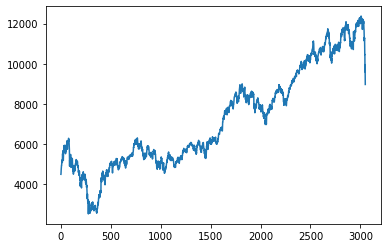

In [4]:
plt.plot(series)
plt.show()

In [34]:
from sklearn import preprocessing
import numpy as np
# N = len(series)
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(series)

factor = 100000
data = series/factor
x = data

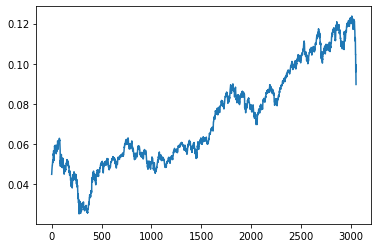

In [14]:
plt.plot(x)
plt.show()

In [15]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d_t' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d_t+%d' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
pre_window=2
post_window=1
time_series_Data=series_to_supervised(x,pre_window,post_window)

starting_pt = (x.shape[1])*pre_window

del_cols = []
for i in range(starting_pt,len(time_series_Data.columns)-1):
    if (i+1)%(x.shape[1]) != 0:
        del_cols.append(i)
    
# time_series_Data.drop(time_series_Data.columns[del_cols], axis=1, inplace=True)
time_series_Data.head(5)

,var1(t-2),var1(t-1),var1_t
2,0.044946,0.045462,0.047324
3,0.045462,0.047324,0.047475
4,0.047324,0.047475,0.048375
5,0.047475,0.048375,0.049322
6,0.048375,0.049322,0.049389


In [17]:
temp_x = []
temp_y = []
for index,rows in time_series_Data.iterrows():
    dummy_x = []
    dummy_y = []
    for i in range(starting_pt):
        dummy_x.append(np.asarray(rows[i]))
    for j in range(starting_pt,len(time_series_Data.columns)):
        dummy_y.append(np.asarray(rows[j]))
    temp_x.append(dummy_x)
    temp_y.append(dummy_y)
temp_x = np.asarray(temp_x)
temp_y = np.asarray(temp_y)

In [18]:
X = temp_x.reshape(temp_x.shape[0],1,temp_x.shape[1])
Y = temp_y
X.shape,Y.shape

((3049, 1, 2), (3049, 1))

In [19]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)
batch_size = 16
epochs = 50
verbose = 0
loss = 'mse'
optimizer = 'adam'

In [20]:
model_sim = Model()
input_layer_sim = Input((X.shape[1], X.shape[2]))
mid_sim= LSTM(50)(input_layer_sim)
output_layer_sim = Dense(Y.shape[1], activation='linear')(mid_sim)
model_sim = Model(input_layer_sim,output_layer_sim)
model_sim.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
# model_sim.summary()
history_sim = model_sim.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
                            validation_data=(test_x, test_y), verbose= verbose)

In [21]:
def attention_layer(hidden_state, cell_state, x_input):
    concat_states = concatenate([hidden_state, cell_state])
    concat_states = Reshape((1, int(concat_states.shape[1])))(concat_states)
    part_1 = Dense(int(x_input.shape[2]),use_bias=False)(concat_states)
    part_2 = Dense(int(x_input.shape[2]),use_bias=False)(x_input)
    res = add([part_1, part_2])
    alpha = Activation('tanh')(res)
    beta = Activation('softmax')(alpha)
    final = multiply([beta,x_input])
    return final

In [22]:
model = Model()
input_layer = Input((X.shape[1], X.shape[2]))
mid, state_h, state_c = LSTM(int(input_layer.shape[2]), return_state=True, return_sequences=True)(input_layer)
res_at = attention_layer(state_h, state_c, input_layer)
lstm_2 = LSTM(50)(res_at)
output_layer = Dense(Y.shape[1], activation='linear')(lstm_2)
model = Model(input_layer,output_layer)
model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
# model.summary()
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose= verbose)

In [23]:
X_ann = temp_x.reshape(temp_x.shape[0],temp_x.shape[1])
Y_ann = temp_y
train_x_ann, test_x_ann, train_y_ann, test_y_ann = train_test_split(X_ann, Y_ann, test_size=0.2, random_state=42)

model_ann = Model()
input_layer = Input((X_ann.shape[1],))
mid = Dense(50)(input_layer)
output_layer = Dense(Y_ann.shape[1], activation='linear')(mid)
model_ann = Model(input_layer,output_layer)
model_ann.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])
# model_ann.summary()
history_ann = model_ann.fit(train_x_ann, train_y_ann, epochs=epochs, batch_size=batch_size, 
                            validation_data=(test_x_ann, test_y_ann), verbose= verbose)

In [24]:
model.save('model_at_lstm_1.h5')
model_sim.save('model_lstm_1.h5')
model_ann.save('model_ann_1.h5')

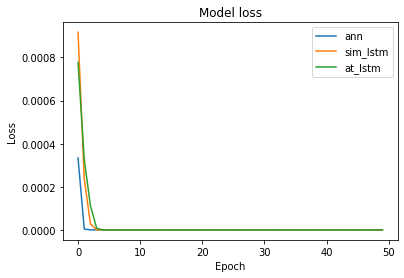

In [25]:
plt.plot(history_ann.history['loss'],label='ann')
plt.plot(history_sim.history['loss'],label='sim_lstm')
plt.plot(history.history['loss'],label='at_lstm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

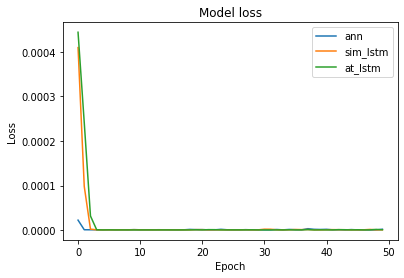

In [26]:
plt.plot(history_ann.history['val_loss'],label='ann')
plt.plot(history_sim.history['val_loss'],label='sim_lstm')
plt.plot(history.history['val_loss'],label='at_lstm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [49]:
def test_sim(model,X,pocket: int = 0,key:str = None):
    predicted = [0]
    gt = []
    pocket_trend = []
    curr_state = 0

    starting_pt = 0
    run_iter = 2000
    
    counter = 0

    for i in range(starting_pt,starting_pt+run_iter):
#         print(" ")
        flag = 0

        if key != 'ann':
            inp = np.asarray([X[i]])
            curr_value = inp[0][0][-1]
        else:
            inp = X[i]
            curr_value = inp[0][-1]

        result = model.predict(inp)
        predicted_value = result[0][0]

        actual = Y[i]
#         print("current_state: ", curr_state)
        if i != starting_pt:
            if predicted_value > curr_value or predicted_value > predicted[-1]:
#                 print("predicted_market_profit")
                if curr_value > predicted_value:
                    if curr_state == 0:
                        curr_state = 1
                        pocket = pocket - curr_value
                        flag = 1
            else:
#                 print("predicted_market_loss")
                if curr_state == 1:
                    curr_state = 0
                    pocket += curr_value

#             print("actions_after_pred: ", curr_state)
            if actual[0] > curr_value:
                pass
    #                 print("actual_market_profit")
            else:
    #                 print("actual_market_loss")
                if curr_state == 1:
                    curr_state = 0
                    pocket += actual[0]
                    counter+=1

        if i == starting_pt+run_iter-1 and curr_state == 1:
            pocket += actual[0]

#         print(curr_value, predicted_value, predicted[-1], actual[0])
#         print("pocket_value: ",pocket)
#         print("after_cycle: ",curr_state)
        pocket_trend.append(pocket)
        predicted.append(predicted_value)
        gt.append(actual[0])
    
    risk = (counter/(run_iter))*100
    # print(pocket)
    return pocket_trend, predicted, gt, risk

In [50]:
starting_pocket = 10
pocket_trend_at_lstm, predicted_at_lstm, gt, risk_at = test_sim(model,X,pocket=starting_pocket)
pocket_trend_sim, predicted_sim, gt_sim, risk_lstm = test_sim(model_sim,X,pocket=starting_pocket)
pocket_trend_ann, predicted_ann, gt_ann, risk_ann = test_sim(model_ann,X,pocket=starting_pocket,key='ann')

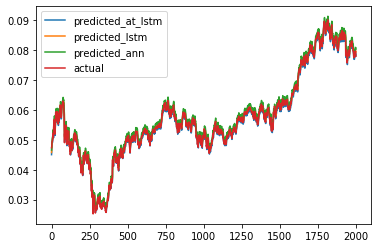

In [51]:
plt.plot(predicted_at_lstm[1:],label='predicted_at_lstm')
plt.plot(predicted_sim[1:],label='predicted_lstm')
plt.plot(predicted_ann[1:],label='predicted_ann')
plt.plot(gt,label='actual')
plt.legend()

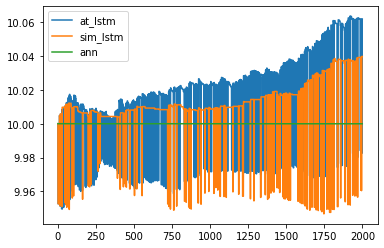

In [52]:
plt.plot(pocket_trend_at_lstm,label='at_lstm')
plt.plot(pocket_trend_sim,label='sim_lstm')
plt.plot(pocket_trend_ann,label='ann')
plt.legend()

In [53]:
print("starting_pocket: ", starting_pocket)
print("final_pocket_at_lstm: ", pocket_trend_at_lstm[-1])
print("final_pocket_sim_lstm: ", pocket_trend_sim[-1])
print("final_pocket_ann: ", pocket_trend_ann[-1])
print(" ")
print("risk_at_lstm: ", risk_at)
print("risk_lstm: ", risk_lstm)
print("risk_ann: ", risk_ann)
print(" ")
at_lstm_pro_per = (pocket_trend_at_lstm[-1]-starting_pocket)*100/starting_pocket
sim_lstm_pro_per = (pocket_trend_sim[-1]-starting_pocket)*100/starting_pocket
ann_pro_per = (pocket_trend_ann[-1]-starting_pocket)*100/starting_pocket
print("profit_perc_at_lstm: ",at_lstm_pro_per)
print("profit_perc_sim_lstm: ",sim_lstm_pro_per)
print("profit_perc_ann: ",ann_pro_per)

starting_pocket:  10
final_pocket_at_lstm:  10.061836508770014
final_pocket_sim_lstm:  10.039739523999994
final_pocket_ann:  9.99995300293
 
risk_at_lstm:  23.5
risk_lstm:  8.799999999999999
risk_ann:  0.05
 
profit_perc_at_lstm:  0.6183650877001412
profit_perc_sim_lstm:  0.39739523999994475
profit_perc_ann:  -0.0004699706999922171


In [54]:
def mape_cal(y_pred,y_true,factor):
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    
    y_pred = np.multiply(y_pred,factor)
    y_true = np.multiply(y_true,factor)
    
    no_test_samples = len(y_pred)
    summation = 0
    rounder_to = 4
    for i in range(no_test_samples):
        curr_val =round(abs(round((y_true[i]-y_pred[i]),rounder_to)/round(y_true[i],rounder_to)),rounder_to)
        summation += curr_val
    mape = round(summation/no_test_samples,rounder_to)
    return mape

def mse_cal(y_pred,y_true):
    no_test_samples = len(y_pred)
    summation = 0
    rounder_to = 7
    for i in range(no_test_samples):
        curr_val =round(round((y_true[i]-y_pred[i]),rounder_to)**2,rounder_to)
        summation += curr_val
    mse = round(summation/no_test_samples,rounder_to)
    return mse

def mae_cal(y_pred,y_true):
    no_test_samples = len(y_pred)
    summation = 0
    rounder_to = 7
    for i in range(no_test_samples):
        curr_val =round(round((y_true[i]-y_pred[i]),rounder_to),rounder_to)
        summation += curr_val
    mae = round(summation/no_test_samples,rounder_to)
    return mae

In [55]:
mape_att = mape_cal(predicted_at_lstm[1:],gt,factor)
mape_lstm = mape_cal(predicted_sim[1:],gt_sim,factor)
mape_ann = mape_cal(predicted_ann[1:],gt_ann,factor)

mae_att = mae_cal(predicted_at_lstm[1:],gt)
mae_lstm = mae_cal(predicted_sim[1:],gt_sim)
mae_ann = mae_cal(predicted_ann[1:],gt_ann)

mse_att = mse_cal(predicted_at_lstm[1:],gt)
mse_lstm = mse_cal(predicted_sim[1:],gt_sim)
mse_ann = mse_cal(predicted_ann[1:],gt_ann)

print("mape_at_lstm: ", mape_att)
print("mape_lstm: ", mape_lstm)
print("mape_ann: ", mape_ann)
print(" ")
print("mae_at_lstm: ", mae_att)
print("mae_lstm: ", mae_lstm)
print("mae_ann: ", mae_ann)
print(" ")
print("mse_at_lstm: ", mse_att)
print("mse_lstm: ", mse_lstm)
print("mse_ann: ", mse_ann)

mape_at_lstm:  0.0142
mape_lstm:  0.014
mape_ann:  0.0239
 
mae_at_lstm:  0.0005259
mae_lstm:  -0.000371
mae_ann:  -0.001226
 
mse_at_lstm:  9e-07
mse_lstm:  9e-07
mse_ann:  2.2e-06


In [56]:
print("profit : risk -- ratio -- at_lstm -- ",at_lstm_pro_per/risk_at)
print("profit : risk -- ratio -- sim_lstm -- ",sim_lstm_pro_per/risk_lstm)
print("profit : risk -- ratio -- ann -- ",ann_pro_per/risk_ann)

profit : risk -- ratio -- at_lstm --  0.02631340798724005
profit : risk -- ratio -- sim_lstm --  0.045158549999993726
profit : risk -- ratio -- ann --  -0.009399413999844342


In [57]:
def save_csv(y_pred, y_true, factor, file_name):
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    
    y_pred = np.multiply(y_pred,factor)
    y_true = np.multiply(y_true,factor)
    
    dummy = {'actual':y_true, 'predicted':y_pred}
    df = pd.DataFrame(dummy)
    df.to_excel(file_name)
    
save_csv(predicted_at_lstm[1:],gt,factor,'output_at_lstm.xlsx')